In [1]:
# import data from OSF
from scipy.io import loadmat

# plot figures
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize 
from matplotlib.widgets import Button
from matplotlib.patches import FancyArrow
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from matplotlib.widgets import Button
import matplotlib.patches as patches

from import_data_osf import get_data

In [2]:
# Function to plot figure

# Function to generate heatmap data
def generate_heatmap_data(iMuscle):
    data_matrix = np.zeros(maps.shape)
    for i in range(ch2xy.shape[0]) :
        data_matrix[int(ch2xy[i][0])][int(ch2xy[i][1])] = sorted_respMean[i][iMuscle]
    return data_matrix  # Generate random heatmap data

# Function to create or update the detailed figure
def update_detailed_figure(iArray, iMuscle, detailed_figure, detailed_axes, d):
    global current_cbar
    
    for key, value in d.items():
        globals()[key] = value

    # Clear previous content
    for ax in detailed_axes:
        ax.clear()

    # Clear all previous content from the figure
    for ax in np.ravel(detailed_axes):  
        ax.cla() 
        
    """if current_cbar is not None:
        try:
            current_cbar.remove()
            current_cbar = None
        except Exception as e:
            print(f"Error removing colorbar: {e}")"""
    if current_cbar is not None:
        detailed_figure.delaxes(current_cbar.ax)
    
    n_repetitions = np.where(stim_channel == iArray + 1)[0].shape[0]
    upLim = np.max(np.mean(sorted_evoked[:,last_button_index,:n_repetitions],1)) * 1000
    upCounts = max([np.where(stim_channel == i)[0].shape[0] for i in range(ch2xy.shape[0])])
    # First imshow 
    minSorted = min(np.min(sorted_evoked[iArray, iMuscle, :n_repetitions, :]), np.min(sorted_filtered[iArray, iMuscle, :n_repetitions, :])) * 1000
    maxSorted = max(np.max(sorted_evoked[iArray, iMuscle, :n_repetitions, :]), np.max(sorted_filtered[iArray, iMuscle, :n_repetitions, :])) * 1000
    im1 =  detailed_axes[2].imshow(sorted_evoked[iArray, iMuscle, :n_repetitions, :] * 1000, vmin=minSorted, vmax=maxSorted, aspect='auto', cmap='Blues')
    cax = detailed_figure.add_axes([0.55, 0.15, 0.03, 0.2]) 
    current_cbar =  detailed_axes[2].figure.colorbar(im1, cax=cax)
    current_cbar.ax.set_ylabel("MEP (mV)", rotation=-90, va="bottom", fontsize=fontsize_axes)
    # Overlay isvalid == 0 in red
    for row in np.where(sorted_isvalid[iArray, iMuscle] == 0)[0]:
        detailed_axes[2].scatter(range(sorted_evoked[iArray, iMuscle, :n_repetitions, :].shape[1]), [row] * sorted_evoked[iArray, iMuscle, :n_repetitions, :].shape[1], 
                    c=sorted_evoked[iArray, iMuscle, :n_repetitions, :][row, :] * 1000, cmap='Reds', marker='s', s=10)
        
    divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.05)
    x_0 = np.where(time == 0)[0][0]
    step = time.shape[0]//5
    detailed_axes[2].set_xticks([i for i in range(x_0%step,time.shape[0], step)])
    detailed_axes[2].set_xticklabels([np.round(time[i],2) for i in range(x_0%step,time.shape[0], step)])
    detailed_axes[2].set_yticks([i for i in range(n_repetitions)])
    # plt.axvline(resp_region[0] * 1000, color="orange")
    detailed_axes[2].set_xlabel("Time (ms)", fontsize=fontsize_axes)
    detailed_axes[2].set_ylabel("Number of trials", fontsize=fontsize_axes)
    detailed_axes[2].set_title(f"Raw {emgs['emgs'][iMuscle]} EMG Stack", fontsize=fontsize_title)
    detailed_axes[2].text(
    0.95, 0.93, "▬ Outliers", fontsize=10, color='red', 
    ha='right', transform=detailed_axes[2].transAxes
    )
    # Plot
    # Create a masked array where invalid points are masked
    # Get data slice
    data = sorted_filtered[iArray, iMuscle, :n_repetitions, :]  # shape: (n_rep, time)
    
    # Get corresponding validity mask
    valid_mask = sorted_isvalid[iArray, iMuscle, :n_repetitions] != 0  # shape: (n_rep,)
    
    # Apply mask and compute mean over valid repetitions
    m = np.mean(data[valid_mask], axis=0) * 1000

    #m = np.mean(sorted_filtered[iArray, iMuscle, :n_repetitions, :], axis=0) * 1000
    std = (np.std(sorted_filtered[iArray, iMuscle, :n_repetitions, :] , axis=0, ddof=1)) / np.sqrt(n_repetitions)*1000
    detailed_axes[0].plot(time, m, label=f"Mean EMG")
    
    
    detailed_axes[0].axvline((resp_region[0] - where_zero)/fs * 1000, color="orange", linestyle="dotted", label="Range to compute maximum peak")
    detailed_axes[0].axvline((resp_region[1] - where_zero)/fs * 1000, color="orange", linestyle="dotted")

    detailed_axes[0].set_ylim(0, upLim)
    detailed_axes[0].set_xlabel("Time (ms)", fontsize=fontsize_axes)
    detailed_axes[0].set_ylabel("MEP (mV)", fontsize=fontsize_axes)
    detailed_axes[0].set_title(f"{emgs['emgs'][iMuscle]} ", fontsize=fontsize_title)
    detailed_axes[0].legend(loc=1, fontsize=fontsize_legend)

    # Histogram
    n, bins, patches = detailed_axes[1].hist(sorted_resp[iArray,iMuscle,:n_repetitions] * 1000 , bins=10, density=False, alpha=0.75)

    detailed_axes[1].set_ylim(0, upCounts)
    detailed_axes[1].set_xlim(0, np.max(sorted_resp[:,iMuscle,:]) * 1000)
    detailed_axes[1].set_xlabel('Peak amplitude', fontsize=fontsize_axes)
    detailed_axes[1].set_ylabel('Counts', fontsize=fontsize_axes)
    detailed_axes[1].set_title(f'Distribution of peak amplitude', fontsize=fontsize_title)
    detailed_axes[1].grid(True)
    
    detailed_axes[3].axis('off')
    detailed_figure.suptitle(f'B. MEP details from electrode {iArray}', fontsize=fontsize_title, y=1)
    #detailed_figure.tight_layout()
    detailed_figure.subplots_adjust(left=0.1, right=0.9, top=0.92, bottom=0.05, wspace=0.5, hspace=0.4)
    detailed_figure.canvas.draw()
    
# Function to update the heatmap based on button click
def on_button_click(event, iMuscle, fig):
    global heatmap_data, last_button_index  # Access the global variable for heatmap data
    last_button_index = iMuscle
    # Generate new data
    heatmap_data = generate_heatmap_data(iMuscle)
    for ax in np.ravel(ax_heatmap):  
        ax.cla()
    im = ax_heatmap.imshow((heatmap_data-np.min(heatmap_data))/(np.max(heatmap_data)-np.min(heatmap_data)), cmap='Blues')
    ax_heatmap.scatter(zero_coords[:, 1], zero_coords[:, 0], color='grey', marker='o', s=50)
    ax_heatmap.set_title(emgs['emgs'][iMuscle], fontsize=fontsize_title)  
    # fig.tight_layout()
    
    # Set title and redraw the plot
    fig.canvas.draw()
    
# Function to handle cell click
def on_heatmap_click(event, d, detailed_figure, detailed_axes, ax_heatmap):
    # Unpack the dictionary into variables
    for key, value in d.items():
        globals()[key] = value
    if event.inaxes == ax_heatmap:
        x, y = event.xdata, event.ydata
        y = ax_heatmap.get_ylim()[1] - y
        x_idx, y_idx = abs(int(round(x))), abs(int(round(y)))
        # print(x_idx, y_idx)
        # Convert data coordinates to pixel coordinates
        trans_data = ax_heatmap.transData
        x_pixel, y_pixel = trans_data.transform((x, y))
        if 0 <= x_idx < heatmap_data.shape[1] and 0 <= y_idx < heatmap_data.shape[0]:  # Check bounds

            for patch in ax_heatmap.patches:
                patch.remove()
            rect = patches.Rectangle((x_idx - 0.5, y_idx - 0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
            ax_heatmap.add_patch(rect)
            
            cell_value = heatmap_data[y_idx, x_idx]  # Access the heatmap data directly
            iArray = np.intersect1d(np.where(ch2xy[:,1] == x_idx)[0], np.where(ch2xy[:,0] == y_idx)[0])[0]
            # print(f"Cell clicked: ({x_idx}, {y_idx}) with value {cell_value}")  # Debugging statement
            if last_button_index is not None :
                update_detailed_figure(iArray, last_button_index, detailed_figure, detailed_axes, d)

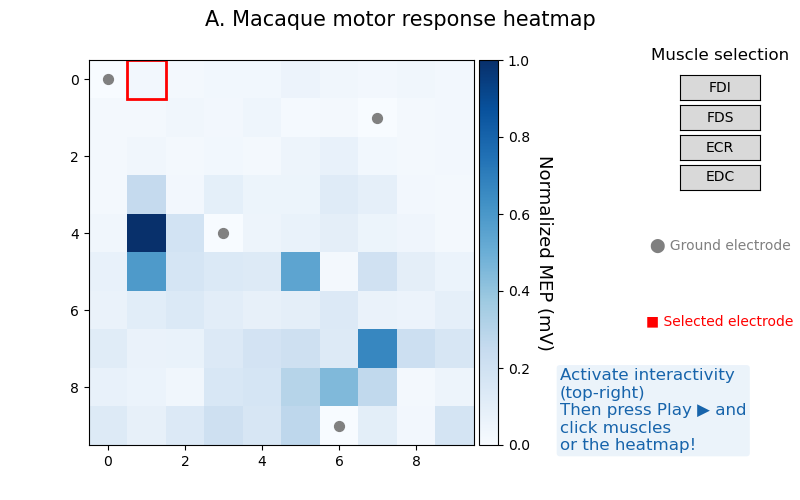

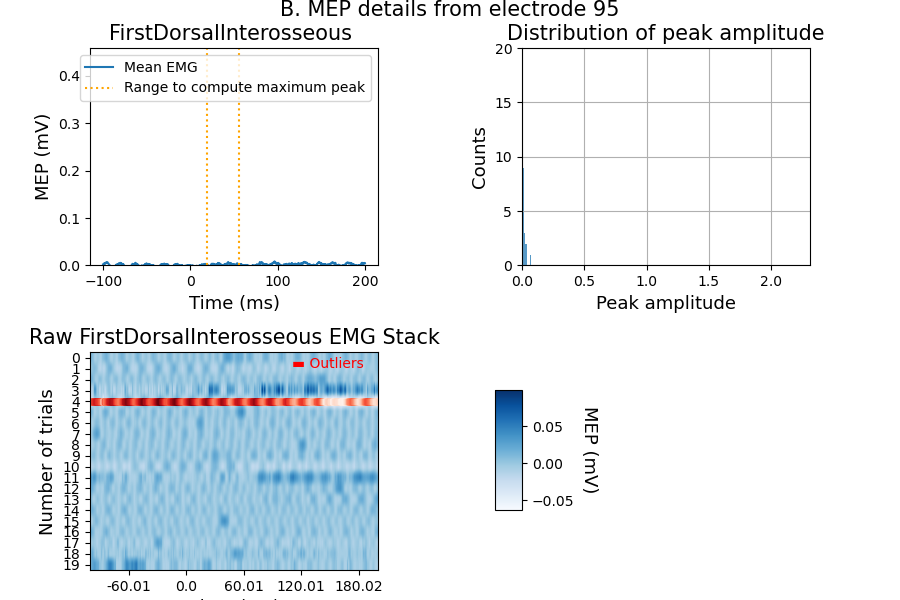

In [5]:
#| label: figMcqcell

# MACAQUE
macaque1_data = loadmat(r"C:\Users\lison\Desktop\figure Symposium 2024\osfstorage-archive\nhp\Macaque1_M1_181212.mat")#("../data/neuromosaics/osfstorage/nhp/Macaque1_M1_181212.mat")
d2 = get_data(is_mat=True, is_macaque=True, mat=macaque1_data, name='Macaque1_M1_181212')

# Unpack the dictionary into variables
for key, value in d2.items():
    globals()[key] = value

# Define some plotting parameters
where_zero = np.where(abs(stimProfile) > 10**(-50))[0][0]
time = np.array([i/fs for i in range(-int(where_zero), evoked_emg.shape[2] - int(where_zero))]) * 1000
fontsize_title = 15
fontsize_axes = 13
fontsize_legend = 10
maps1 = np.copy(maps)

# PLOT
maps = maps1
current_cbar = None

# Create a unique identifier for the new main figure
fig_number = len(plt.get_fignums()) + 1  # Total existing figures + 1
fig2, (ax_heatmap, ax_buttons) = plt.subplots(
    1, 2, figsize=(8, 5), gridspec_kw={'width_ratios': [4, 1]}, num=f'Main Plot {fig_number}'
)
plt.subplots_adjust(left=0.1, right=0.9, wspace=0.4)
fig2.suptitle(f'A. Macaque motor response heatmap', fontsize=fontsize_title)
# Create the initial heatmap plot
heatmap_data = generate_heatmap_data(0)

im = ax_heatmap.imshow(
    (heatmap_data - np.min(heatmap_data)) / (np.max(heatmap_data) - np.min(heatmap_data)),
    cmap='Blues'
)
zero_coords = np.argwhere(heatmap_data == 0)
ax_heatmap.scatter(zero_coords[:, 1], zero_coords[:, 0], color='grey', marker='o', s=50)

divider = make_axes_locatable(ax_heatmap)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = ax_heatmap.figure.colorbar(im, cax=cax)
cbar.ax.set_ylabel("Normalized MEP (mV)", rotation=-90, va="bottom", fontsize=fontsize_axes)

x = 1
y = 0
array10 = np.intersect1d(np.where(ch2xy[:,1] == x)[0], np.where(ch2xy[:,0] == y)[0])[0]
rect = patches.Rectangle((x - 0.5, y - 0.5), 1, 1, linewidth=2, edgecolor='red', facecolor='none')
ax_heatmap.add_patch(rect)

# Initialize button to Muscle 0
last_button_index = 0

# Hide the buttons axis frame
ax_buttons.set_visible(True)
ax_buttons.spines['top'].set_visible(False)
ax_buttons.spines['right'].set_visible(False)
ax_buttons.spines['left'].set_visible(False)
ax_buttons.spines['bottom'].set_visible(False)
ax_buttons.xaxis.set_visible(False)
ax_buttons.yaxis.set_visible(False)
ax_buttons.set_xticks([])
ax_buttons.set_yticks([])

# Create buttons and assign callbacks
button_positions = [0.8 - i * 0.06 for i in range(n_muscles)]  # Vertical positions of buttons
button_axes = [plt.axes([0.85, pos, 0.1, 0.05]) for pos in button_positions]
buttons = [Button(button_axes[i], emgs['emgsabr'][i]) for i in range(n_muscles)]
# Add a title above the buttons
square_symbol = '\u25A0'
plt.text(0.90, 0.88, "Muscle selection", fontsize=12, ha='center', transform=plt.gcf().transFigure)
plt.text(0.90, 0.50, "⬤ Ground electrode", fontsize=10, color='grey', ha='center', transform=plt.gcf().transFigure)
plt.text(0.90, 0.35, f"{square_symbol} Selected electrode", fontsize=10, color='red', ha='center', transform=plt.gcf().transFigure)
cmap = plt.get_cmap("Blues")
deep_blue = cmap(0.8)  # Dark blue for text
light_blue = cmap(0.1)  # Light blue for background
plt.text(0.7, 0.1, 
    "Activate interactivity\n(top-right)\nThen press Play ▶ and\nclick muscles\nor the heatmap!",
    fontsize=12, color=deep_blue, ha='left', fontfamily='DejaVu Sans',
         bbox=dict(boxstyle="round,pad=0.2", edgecolor='none', facecolor=light_blue, alpha=0.7),
         transform=plt.gcf().transFigure )
plt.show()

for i, button in enumerate(buttons):
    button.on_clicked(lambda event, index=i: on_button_click(event, index, fig2))

# Create a unique identifier for the detailed figure
detailed_fig_number = len(plt.get_fignums())  # Total existing figures + 1
detailed_figure2, detailed_axes2 = plt.subplots(
    2, 2, figsize=(9, 6), num=f'Detailed View {detailed_fig_number}'
)
# Connect the heatmap click event
fig2.canvas.mpl_connect('button_press_event', lambda event: on_heatmap_click(event, d2, detailed_figure2, detailed_axes2, ax_heatmap))

plt.subplots_adjust(wspace=0.5)
detailed_axes2 = detailed_axes2.flatten()
update_detailed_figure(array10, 0, detailed_figure2, detailed_axes2, d2)